In [ ]:
# Mount google drive folder
from google.colab import drive
drive.mount('/content/drive/')

import os
import numpy as np
import typing
import gdal
import keras
import tensorflow as tf

from skimage import exposure

%pip install git+https://github.com/karolzak/keras-unet

# define dataset directory
from google.colab import drive

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-t4px0rt3
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-t4px0rt3
  Created wheel for keras-unet: filename=keras_unet-0.1.2-py3-none-any.whl size=17008 sha256=28a8163ca551456e36974c8c35d716f28469fbca306cbfcf8ed4ae1d7b4d674d
  Stored in directory: /tmp/pip-ephem-wheel-cache-mj12b0ta/wheels/ca/e1/e8/61638b7e082fcc34cf9b3e6ebf1fb852db0d19a1555b8aa13d
Successfully built keras-unet


In [ ]:
BASE_PATH = "/content/drive/My Drive/field_delineation"
INPUT_PATH = BASE_PATH + "/data/"
OUTPUT_PATH = BASE_PATH + "/networks"
IMAGE_PATH = "/Original"
LABEL_PATH = "/Classified"

INCLUDE_FOLDERS = ["Flevoland", "Friesland", "Gelderland", "Limburg", "Overijssel", "Zeeland", "Zuid-Holland"]

LEGEND = {
    1: 'Other',
    2: 'Field Boundary'
}

# To assess the accuracy you have to define the networks UUID and name here
NETWORK_UUID = "22f7adf6-f864-11ec-be5e-0242ac1c0002"

# Allowed Values:
#   * FCNDK5
#   * FCNDK6
#   * UNet2
#   * UNet3

NETWORK_NAME = "unet3"

In [ ]:
import imp, h5py
import dill, pickle
import uuid
imp.reload(h5py)

from tensorflow.python.keras import backend as K
sess = K.get_session()

from tensorflow.compat.v1.keras.backend import set_session


# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))



# Helper functions for the networks - import/export of network

# These two functions help to export the network and import it.
# That allows to skip the training at a later stage.
# This way we can evaluate the training and its accuracy

class ModelHistory:
    """Just a small container class to hold relevant information of a trained
    model.
    """

    def __init__(self, uuid, name, model, history, readme):
        """Create a new instance of this class
        :param uuid: A unique identifier of the network
        :param name: The networks name
        :param model: The pretrained model
        :param history: The training history of the model
        :param readme: A small readme with a summary of training parameters
        """
        self.uuid = uuid
        self.name = name
        self.model = model
        self.history = history
        self.readme = readme


def get_file_names(uuid, name):
    """Generates three file names for the model, weights and history file and
    the networks readme.

    File name order of returned tuple:
        * readme
        * model
        * weights
        * history

    :param uuid: Universal unique identifier of a trained network
    :param name: The networks name
    :return: Tuple with files in the order mentioned above
    """
    base = f"{OUTPUT_PATH}/{str(uuid)}-{name}"

    f_readme = f"{base}-readme.txt"
    f_model = f"{base}-model.h5"
    f_weights = f"{base}-weights.h5"
    f_history = f"{base}-history"

    return (f_readme, f_model, f_weights, f_history)


def export_model(m: ModelHistory):
    """If a model is sufficiently trained, it can be exported. This allows to
    simply save the models state and the training history. Whenever one want to
    use the model the next time, the training can be skipped, since the trained
    model can just be imported from files.

    :param model_history: The trained model and history to be stored
    """
    f_readme, f_model, f_weights, f_history = get_file_names(m.uuid,m.name)

    # save readme
    with open(f_readme, 'w') as f:
        f.write(m.readme)
    print(f"Exported README: {f_readme}")

    # save models & weights
    m.model.save(f_model)
    print(f"Exported model: {f_model}")
    m.model.save_weights(f_weights)
    print(f"Exported weights: {f_weights}")

    # save history
    with open(f_history, "wb") as f:
        pickle.dump(m.history, f)
    print(f"Exported history: {f_history}")

def import_model(uuid, name):
    """Previously exported models can be imported with this funciton.
    :param uuid: The networks uuid
    :param name: The networks name
    :return: Instance of ModelHistory
    """
    f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

    # Load readme
    with open(f_readme, 'r') as f:
        readme = "".join(f.readlines())
    print(f"Imported README: {f_readme}")

    # Load model & weights
    model = tf.keras.models.load_model(f_model)
    print(f"Imported model: {f_model}")
    model.load_weights(f_weights)
    print(f"Imported weights: {f_weights}")

    # Load history
    with open(f_history, 'rb') as f:
        history = pickle.load(f)
    print(f"Imported history: {f_history}")

    return ModelHistory(uuid, name, model, history, readme)

In [ ]:
# Loading the test data based on readme
# here we will only access the training provinces and the their keys 
# which was used for testing the model after training it.

model_history = import_model(NETWORK_UUID, NETWORK_NAME)

readme = model_history.readme
#print(readme)

# now we will consider the test set information from the readme file
test_set = readme.split("Test set:")[1]
test_set = test_set.split('\n')
#test_set

test_key_set = []

for entry in test_set:
  entry = entry.strip()
  # this step will ensure that the empty lines are skipped
  if not entry:
    continue
  
  # now the unnecessary characters are removed
  entry = entry.replace("(","")
  entry = entry.replace(")","")
  entry = entry.replace(",","")

  # the first and second elements will be stored in province and index
  province, index = tuple(entry.split())

  test_key_set.append((province, int(index)))

  print(f"Added the key to the testing set: ({province}, {index})")

print(test_key_set)

Imported README: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-readme.txt
Imported model: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-model.h5
Imported weights: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-weights.h5
Imported history: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-history
Added the key to the testing set: (zeeland, 32)
Added the key to the testing set: (friesland, 165)
Added the key to the testing set: (zeeland, 3)
Added the key to the testing set: (zeeland, 22)
Added the key to the testing set: (friesland, 164)
Added the key to the testing set: (overijssel, 35)
Added the key to the testing set: (flevoland, 36)
Added the key to the testing set: (zeeland, 23)
Added the key to the testing set: (friesland, 166)
Added the key to the testing set: (overijssel, 20)
Added the key to the

In [ ]:
# Loading input data

# Input data is loaded into two dictionaries: 

# images: contains the 4-band images. The values are loaded as ints.
# labels: contains 3D arrays in which each pixel is assigned with a label "1" = other and "2" = field boundary


def key_generator(file_name):
    """Generates the key of a file based on the file name. The resulting key is
    a tuple of the province as string & the file number index as int,
    e.g. ("gelderland", 29)
    """
    file_name = file_name.lower()
    file_name = file_name.replace("classified_", "")
    file_name = file_name.replace("original_", "")
    file_name = file_name.replace(".tif", "")
    # TODO: Some images are named incorrectly
    #       (e.g. no '_' between the province name and the image index)
    (province, index) = tuple(file_name.split("_"))
    index = int(index)
    return (province, index)

def gtiff_to_array(file_path):
    #Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)

def transform_classification_image(input):
    """Takes the classification image input (in RGB format as 3D array) and 
    creates a 2D array out of this. The innermost array expects either values of
    [0, 0, 0] of [255, 255, 255] since this is the colouring we assigned to the
    classified images.

    :param input: 3D input image (classification)
    :return: 2D array image with labels 1 for 'other' and 2 for 'field_boundaries'
    """

    # Out of the 3D input array it takes the "max" element out of the array
    # This will either be 0 or 255. This function is just called to transform 
    # the 3D array to a 2D array.
    result = np.reshape(np.max(input, axis=2), (input.shape[0], input.shape[1], 1))

    # Now the array consists of pixels with values "0" or "255". We transform
    # each value, that is larger than 0 (i.e. 255) and assign the label "2" to
    # it. Each other element (i.e. 0) will get assigned the label "1".
    result = np.where(result > 0, 2, 1)
    return result

# Dictionaries which contain the input data
x_dict = {}
y_dict = {}

for folder in INCLUDE_FOLDERS:
  original = INPUT_PATH + folder + IMAGE_PATH
  classified = INPUT_PATH + folder + LABEL_PATH
  for f in os.listdir(original):
    key = key_generator(f)
    if key in test_key_set:
      x_dict[key] = gtiff_to_array(original + "/" + f)

  for f in os.listdir(classified):
    key = key_generator(f)
    if key in test_key_set:
      value = gtiff_to_array(classified + "/" + f)
      # transforming the classified image from RGB to labels 1 and 2
      value = transform_classification_image(value)
      y_dict[key] = value

assert len(test_key_set) == len(x_dict)
assert len(test_key_set) == len(y_dict)

print(f"Shape of a test image file: {list(x_dict.values())[0].shape}")
print(f"Shape of a test lable file: {list(y_dict.values())[0].shape}")

print(f"Total number of image and label tiles: {len(x_dict)}")

Shape of a test image file: (800, 800, 4)
Shape of a test lable file: (800, 800, 1)
Total number of image and label tiles: 13


In [ ]:
# Normalizing images

# Normalizing all input images into values in the interval [0, 1].
# All bands are normalized seperately, which means, the min & max
# of each band is calculated based on each band of the image data.

def normalize(val, min, max):
    """Normalizes the value of a single pixel. Takes into account the minimum,
    and maximum value.

    v_normalized = (v - min) / (max - min)

    :param val: integer value
    :param min: integer minimum
    :param max: integer maximum
    :return: single floating point number in [0, 1]
    """
    return (val - min) / (max - min)


def normalize_array(arr):
    """Takes a 3D array as input, iterates over the bands and normalizes those.

    :param arr: input array (original image data) 
    :return: normalized data with values between 0 and 1
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        min = arr[:, :, i].min()
        max = arr[:, :, i].max()

        arr_norm = (arr - min) / (max - min)
    
    return arr_norm


for k, v in x_dict.items():
    x_dict[k] = normalize_array(v)
    print(f"Performed normalization of {k[0]}_{k[1]}")

Performed normalization of flevoland_36
Performed normalization of friesland_166
Performed normalization of friesland_161
Performed normalization of friesland_165
Performed normalization of friesland_164
Performed normalization of overijssel_35
Performed normalization of overijssel_20
Performed normalization of zeeland_22
Performed normalization of zeeland_19
Performed normalization of zeeland_51
Performed normalization of zeeland_32
Performed normalization of zeeland_3
Performed normalization of zeeland_23


In [ ]:
# Network builder functions
# Dynamic builder function for the FCN-DK.
# Supported are the layers 2 up to and including 6.

from keras.layers import Activation, BatchNormalization, Convolution2D, LeakyReLU, Reshape, ZeroPadding2D
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

from keras_unet.models import satellite_unet

In [ ]:
# To compile the model, also the optimizer has to be defined
NETWORK_OPTIMIZER = "Adam"

# Same optimizer parameters as in the training run
SGD_LEARNING_RATE = 0.01
SGD_MOMENTUM = 0.9

ADAM_LEARNING_RATE = 0.1
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-07

m = import_model(NETWORK_UUID, NETWORK_NAME)
readme = m.readme
model = m.model
history = m.history
print(f"Loaded the existing network: {NETWORK_UUID} {NETWORK_NAME}")

print(readme)

Imported README: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-readme.txt
Imported model: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-model.h5
Imported weights: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-weights.h5
Imported history: /content/drive/My Drive/field_delineation/networks/22f7adf6-f864-11ec-be5e-0242ac1c0002-unet3-history
Loaded the existing network: 22f7adf6-f864-11ec-be5e-0242ac1c0002 unet3
 
Training Config
-------------------------------------
NETWORK
  Uuid:               22f7adf6-f864-11ec-be5e-0242ac1c0002
  Name:               unet3
  Optimizer:          Adam


PARAMETERS
  Bands:              4
  Classes:            2
  Epochs:             800
  Batch Size:         8

OPTIMIZER (Adam)
  Learning Rate:    0.0015
  Beta1:            0.9
  Beta2:            0.999
  Epsilon:          1e-06
  
EXECUTION SUMMARY
  Patches:   

In [ ]:
from matplotlib import pyplot

def evaluate_predictions(
    input: np.ndarray, 
    nc:int, f_weights: str,
    optimizer: tf.keras.optimizers.Optimizer,
    model_builder: typing.Callable,
) -> np.ndarray:
    """Takes an input image, patches it into smaller patches and feeds the model
    with each of the patches. The output samples are patches of the predicted
    classification. These patches are combined into one large image, that can
    be compared with the classified image of the corresponding input data.

    :param input: test image to evaluate
    :param nc: Number of classes/labels
    :param f_weights: File path to the corresponding weights file
    :param optimizer: Optimizer for the network
    :param model_build: method to create the model
    :return: 2D ndarray of the predicted labels
    """

    x,y, bands = x_test.shape

    # building a model and loading the model weights
    model = model_builder(x,y,bands,nc)
    model.compile(optimizer = optimizer, 
                  loss = 'binary_crossentropy', 
                  metrics = 'accuracy')
    model.load_weights(f_weights)

    # predicting the field boundaries
    # increasing the dimension to perform the batch predictions
    input = np.expand_dims(input, 0)
    prediction = model.predict(input)[0]
    prediction = np.argmax(prediction, axis = 2) + 1

    return prediction

def print_map(labels: np.ndarray, title:str):
    """Will print output based on given input labels.

    Coloring:
        Label 1 = other = black
        Label 2 = boundary = white
    
    Remark: The expected data structure is a 2 dimensional array with the int
            value of the corresponding label.

    :param labels: The 2D array of labels per pixel
    :param title: The plot title
    """
    # creating the image in RGB
    
    x,y = labels.shape[0], labels.shape[1]
    img = np.zeros((x,y,3), dtype = np.uint8)

    for i in range(img.shape[2]):
      img[:,:,i] = np.where(labels[:,:] == 2,255,0)

    # drawing the plot
    fig = pyplot.figure(figsize = (7,7))
    pyplot.imshow(img)
    pyplot.suptitle(title)
    pyplot.show()

1/1 [==============================] - 14s 14s/step


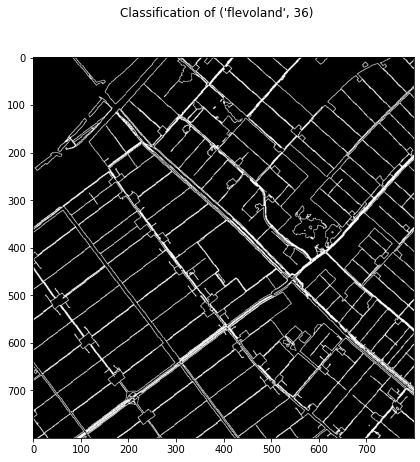

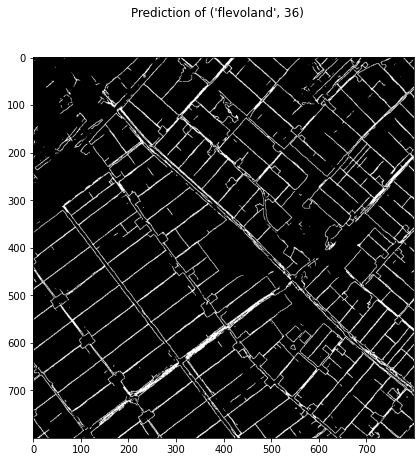

1/1 [==============================] - 0s 437ms/step


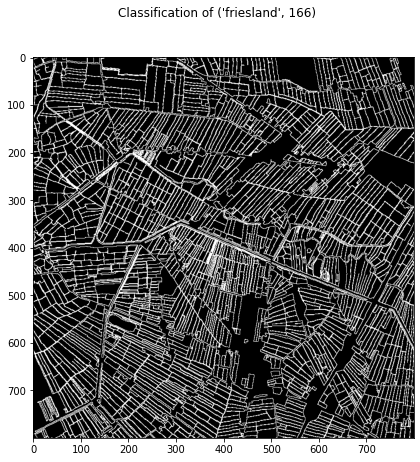

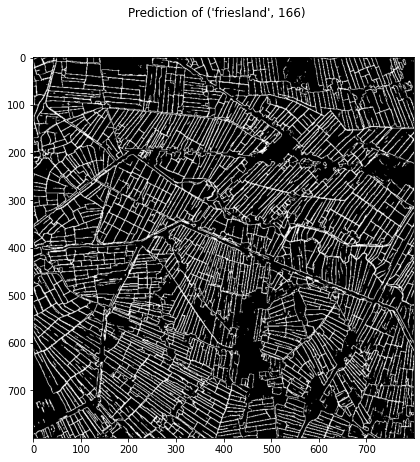

1/1 [==============================] - 0s 461ms/step


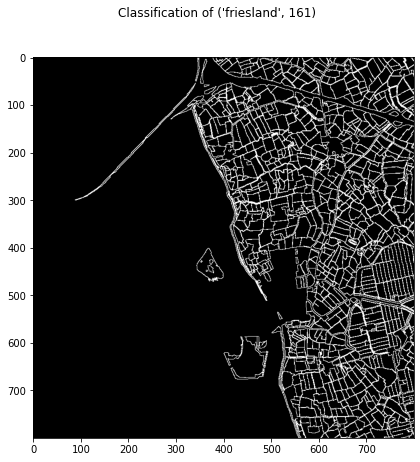

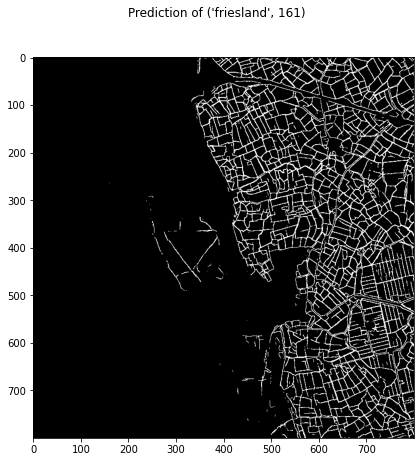

1/1 [==============================] - 0s 431ms/step


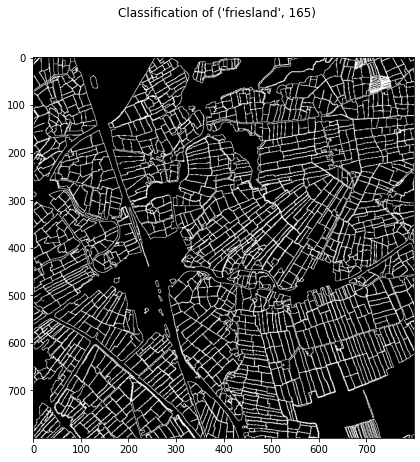

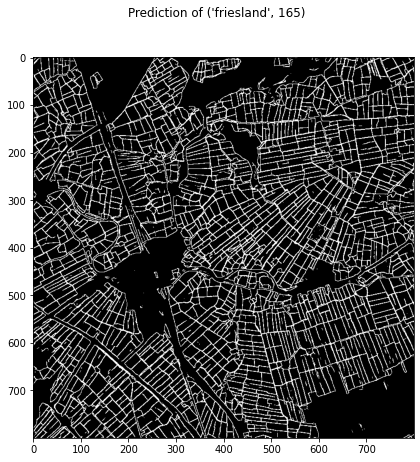

1/1 [==============================] - 0s 428ms/step


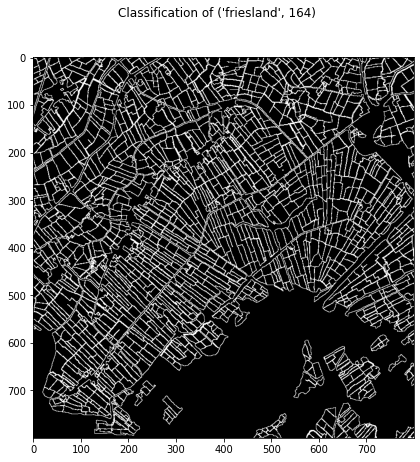

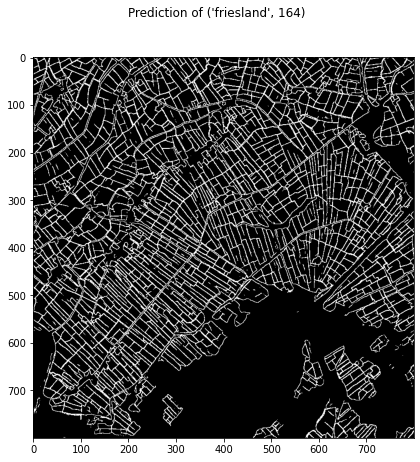

1/1 [==============================] - 0s 427ms/step


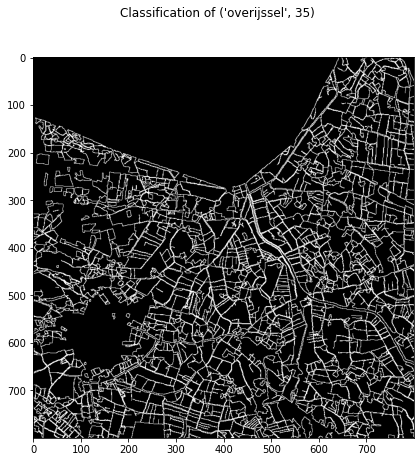

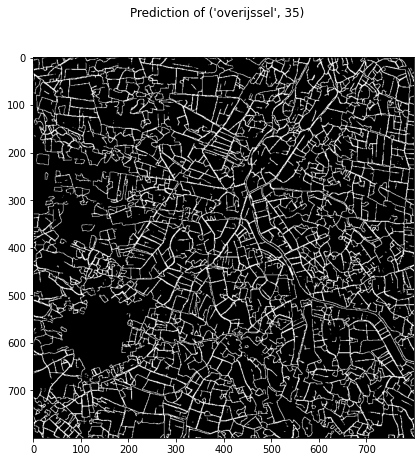

1/1 [==============================] - 0s 431ms/step


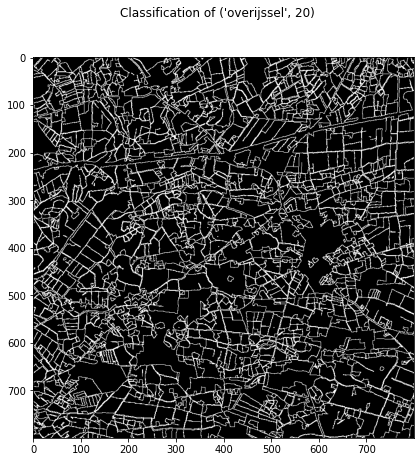

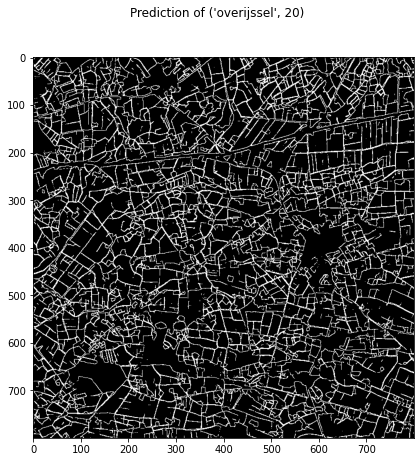

1/1 [==============================] - 0s 452ms/step


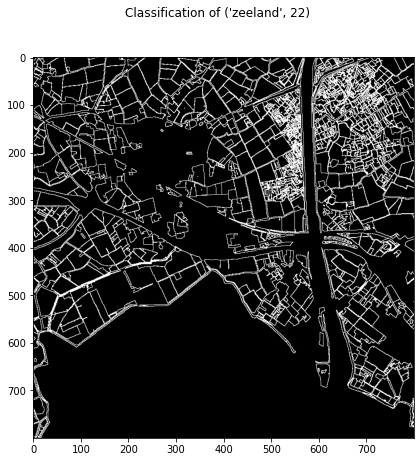

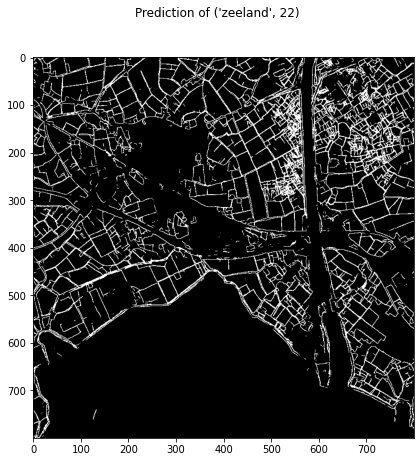

1/1 [==============================] - 0s 422ms/step


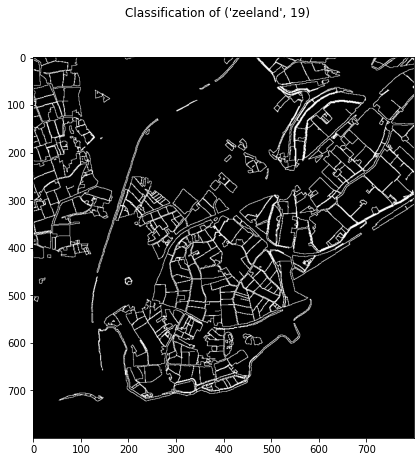

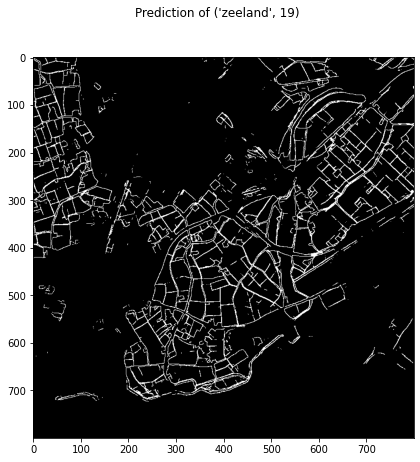

1/1 [==============================] - 0s 426ms/step


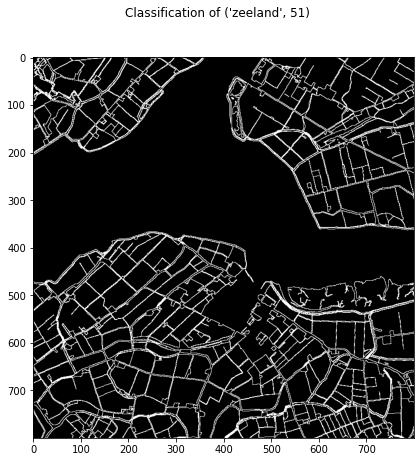

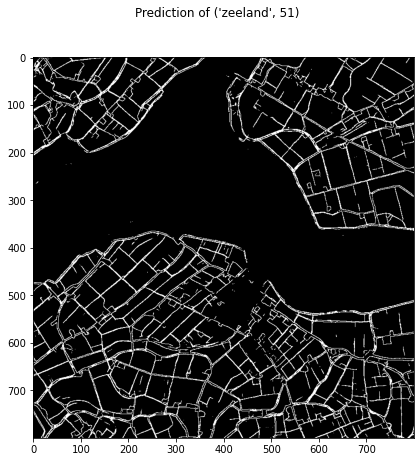

1/1 [==============================] - 0s 448ms/step


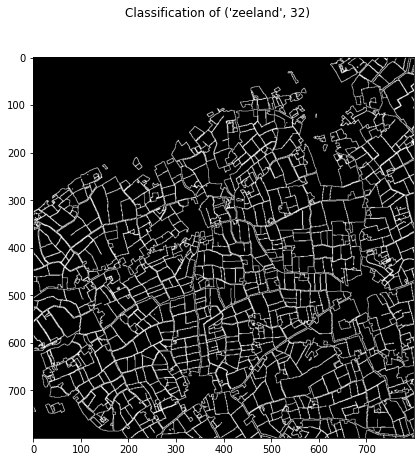

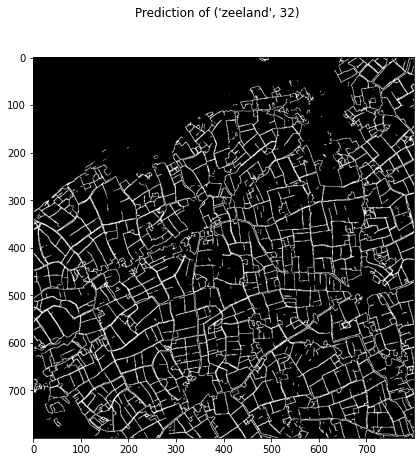

1/1 [==============================] - 0s 455ms/step


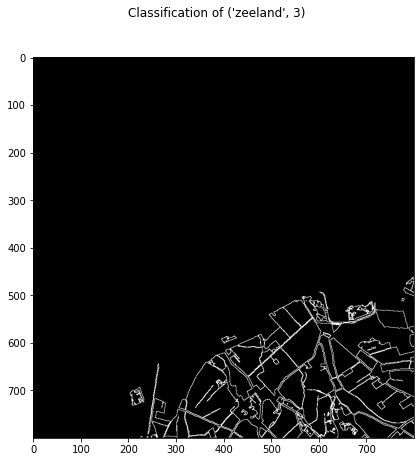

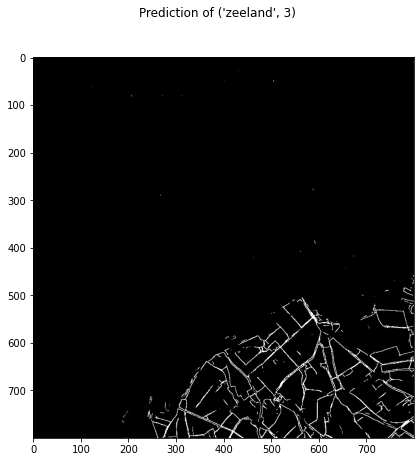

1/1 [==============================] - 0s 424ms/step


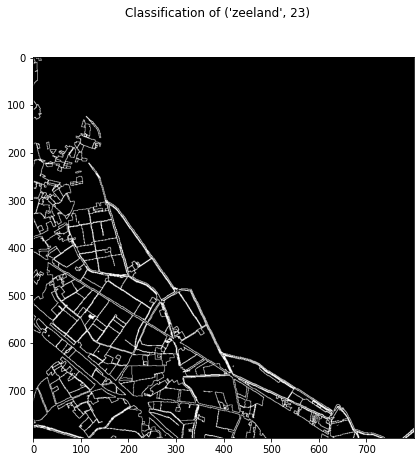

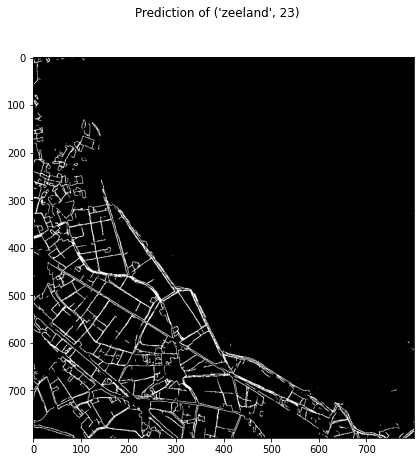

In [ ]:
# Evaluation of the test data

# In this step, the previously created test data set is feeded to
# the network. The network responds with a prediciton of field
# boundaries. The resulting data will be used to assess the accuracy of the network.
predictions = dict()

for k in x_dict.keys():
  x_test = x_dict[k]
  y_test = y_dict[k]

  (_,_, f_weights, _) = get_file_names(NETWORK_UUID, NETWORK_NAME)
  
  result = evaluate_predictions(x_test, NUMBER_CLASSES, f_weights,OPTIMIZER, model_builder,)
  predictions[k] = result

  label = np.reshape(y_test, result.shape)

  print_map(label, f"Classification of {k}")
  print_map(result, f"Prediction of {k}")

In [ ]:
import pandas
from IPython.display import display

def get_binary_confusion_matrix(pred, exp):
    """
    :param pred: ndarray with the predicted classes
    :param exp: preclassified data of the input images
    :return: A tuple of values that represent the confusion matrix
    """
    if exp.size != pred.size:
        raise ValueError("Invalid sizes of prediction and label input")

    exp = np.where(exp[:, :] == 2, True, False)
    pred = np.where(pred[:, :] == 2, True, False)

    tp, fp, fn, tn = 0, 0, 0, 0
    tp = np.sum(np.logical_and(exp, pred))
    fp = np.sum(np.logical_and(np.logical_not(exp), pred))
    fn = np.sum(np.logical_and(exp, np.logical_not(pred)))
    tn = np.sum(np.logical_and(np.logical_not(exp), np.logical_not(pred)))

    return (tp, fp, fn, tn)

"""
Confusion Matrix: flevoland 79
================================

	Actual Other 	Actual Field Boundary
Prediction Other 	619184 (96.748%) 	10495 (1.64%)
Prediction Field Boundary 	4758 (0.743%) 	5563 (0.869%)
"""


def print_binary_confusion_matrix(title, tp, fp, fn, tn):
    cm = [tp, fp, fn, tn]
    total = sum(cm)
    # percentages
    #(ptp, pfp, pfn, ptn) = tuple([int(100 * cm[i]) for i in range(len(cm))])
    (ptp, pfp, pfn, ptn)= tuple([100 * cm[i] / total for i in range(len(cm))])

    header_row = ["Actual Other", "Actual Field Boundary", "Sum"]
    header_col = ["Prediction Other", "Prediction Field Boundary", "Sum"]

    data = [
        [f"{tn} ({round(ptn, 3)}%)", f"{fn} ({round(pfn, 3)}%)", tn + fn],
        [f"{fp} ({round(pfp, 3)}%)", f"{tp} ({round(ptp, 3)}%)", fp + tp],
        [tn + fp, fn + tp, ""]
    ]

    df = pandas.DataFrame(data, header_col, header_row)
    print(f"Confusion Matrix: {title}")
    print("=" * 32)
    display(df)
    print("\n" * 3)


def print_scores(title, tp, fp, fn, tn):
    """Calculates and prints the typical precision scores of a machine learning
    algorithm.

    :param title: Title to be printed
    :param tp: number of true positives
    :param fp: number of false positives
    :param fn: number of false negatives
    :param tn: number of true negatives
    """
    total = sum([tp, fp, fn, tn])
    # Accuracy
    # How many pixels are classified correctly
    accuracy = (tp + tn) / total

    # Precision / Specification
    # How accurate can the network determine field boundaries
    precision = tp / (tp + fp)

    # Recall / Sensitivity
    # How many boundaries did we detect out of all actual field boundary pixels
    recall = tp / (tp + fn)

    # F1 score
    # harmonic mean of recall & precision
    f1 = ( 2 * ( precision * recall ) ) / ( precision + recall )
    #f1 = 2 * ( ( precision * recall ) / (precision + recall) )


    accuracy *= 100
    precision *= 100
    recall *= 100
    f1 *= 100

    print(f"Accuracy Assessment: {title}")
    print("=" * 32)
    print("{:<32} {:<10} %".format("Overall Accuracy", round(accuracy, 3)))
    print("{:<32} {:<10} %".format("Precision", round(precision, 3)))
    print("{:<32} {:<10} %".format("Recall", round(recall, 3)))
    print("{:<32} {:<10} %".format("F1 Score", round(f1, 3)))
    print("\n" * 3)


def run_accuracy_assessment():
    """Simply performs an accuracy assessment based on the entire test data set
    and the results of the evaluation.
    """
    #        tp fp fn tn
    total = [0, 0, 0, 0]

    for k, p in predictions.items():
        # k = key, l = label, p = prediction
        l = np.reshape(y_dict[k], p.shape)
        cm = get_binary_confusion_matrix(p, l)
        (tp, fp, fn, tn) = cm

        # Cumulate values
        for i in range(len(total)):
            total[i] += cm[i]
        
        # Print confusion matrix
        print_binary_confusion_matrix(f"{k[0]} {k[1]}", tp, fp, fn, tn)
        print_scores(f"{k[0]} {k[1]}", tp, fp, fn, tn)

    (tp, fp, fn, tn) = tuple(total)
    print_binary_confusion_matrix("Cumulated", tp, fp, fn, tn)
    print_scores("Cumulated", tp, fp, fn, tn)

run_accuracy_assessment()

Confusion Matrix: flevoland 36


Actual Other Actual Field Boundary     Sum
Prediction Other           555856 (86.852%)        25891 (4.045%)  581747
Prediction Field Boundary    19314 (3.018%)        38939 (6.084%)   58253
Sum                                  575170                 64830





Accuracy Assessment: flevoland 36
Overall Accuracy                 92.937     %
Precision                        66.845     %
Recall                           60.063     %
F1 Score                         63.273     %




Confusion Matrix: friesland 166


Actual Other Actual Field Boundary     Sum
Prediction Other           447372 (69.902%)        52264 (8.166%)  499636
Prediction Field Boundary    41037 (6.412%)        99327 (15.52%)  140364
Sum                                  488409                151591





Accuracy Assessment: friesland 166
Overall Accuracy                 85.422     %
Precision                        70.764     %
Recall                           65.523     %
F1 Score                         68.043     %




Confusion Matrix: friesland 161


Actual Other Actual Field Boundary     Sum
Prediction Other           557613 (87.127%)        25019 (3.909%)  582632
Prediction Field Boundary    16839 (2.631%)        40529 (6.333%)   57368
Sum                                  574452                 65548





Accuracy Assessment: friesland 161
Overall Accuracy                 93.46      %
Precision                        70.647     %
Recall                           61.831     %
F1 Score                         65.946     %




Confusion Matrix: friesland 165


Actual Other Actual Field Boundary     Sum
Prediction Other           486118 (75.956%)        35984 (5.622%)  522102
Prediction Field Boundary    33636 (5.256%)       84262 (13.166%)  117898
Sum                                  519754                120246





Accuracy Assessment: friesland 165
Overall Accuracy                 89.122     %
Precision                        71.47      %
Recall                           70.075     %
F1 Score                         70.766     %




Confusion Matrix: friesland 164


Actual Other Actual Field Boundary     Sum
Prediction Other           494174 (77.215%)         34878 (5.45%)  529052
Prediction Field Boundary     30786 (4.81%)       80162 (12.525%)  110948
Sum                                  524960                115040





Accuracy Assessment: friesland 164
Overall Accuracy                 89.74      %
Precision                        72.252     %
Recall                           69.682     %
F1 Score                         70.944     %




Confusion Matrix: overijssel 35


Actual Other Actual Field Boundary     Sum
Prediction Other           495415 (77.409%)        39894 (6.233%)  535309
Prediction Field Boundary    49502 (7.735%)        55189 (8.623%)  104691
Sum                                  544917                 95083





Accuracy Assessment: overijssel 35
Overall Accuracy                 86.032     %
Precision                        52.716     %
Recall                           58.043     %
F1 Score                         55.251     %




Confusion Matrix: overijssel 20


Actual Other Actual Field Boundary     Sum
Prediction Other           485747 (75.898%)        44707 (6.985%)  530454
Prediction Field Boundary    39440 (6.162%)       70106 (10.954%)  109546
Sum                                  525187                114813





Accuracy Assessment: overijssel 20
Overall Accuracy                 86.852     %
Precision                        63.997     %
Recall                           61.061     %
F1 Score                         62.494     %




Confusion Matrix: zeeland 22


Actual Other Actual Field Boundary     Sum
Prediction Other           526193 (82.218%)        39463 (6.166%)  565656
Prediction Field Boundary    27786 (4.342%)        46558 (7.275%)   74344
Sum                                  553979                 86021





Accuracy Assessment: zeeland 22
Overall Accuracy                 89.492     %
Precision                        62.625     %
Recall                           54.124     %
F1 Score                         58.065     %




Confusion Matrix: zeeland 19


Actual Other Actual Field Boundary     Sum
Prediction Other           569606 (89.001%)        26988 (4.217%)  596594
Prediction Field Boundary    18310 (2.861%)        25096 (3.921%)   43406
Sum                                  587916                 52084





Accuracy Assessment: zeeland 19
Overall Accuracy                 92.922     %
Precision                        57.817     %
Recall                           48.184     %
F1 Score                         52.563     %




Confusion Matrix: zeeland 51


Actual Other Actual Field Boundary     Sum
Prediction Other           552726 (86.363%)        27960 (4.369%)  580686
Prediction Field Boundary    18662 (2.916%)        40652 (6.352%)   59314
Sum                                  571388                 68612





Accuracy Assessment: zeeland 51
Overall Accuracy                 92.715     %
Precision                        68.537     %
Recall                           59.249     %
F1 Score                         63.555     %




Confusion Matrix: zeeland 32


Actual Other Actual Field Boundary     Sum
Prediction Other           532454 (83.196%)        31398 (4.906%)  563852
Prediction Field Boundary     26817 (4.19%)        49331 (7.708%)   76148
Sum                                  559271                 80729





Accuracy Assessment: zeeland 32
Overall Accuracy                 90.904     %
Precision                        64.783     %
Recall                           61.107     %
F1 Score                         62.891     %




Confusion Matrix: zeeland 3


Actual Other Actual Field Boundary     Sum
Prediction Other           618961 (96.713%)         9051 (1.414%)  628012
Prediction Field Boundary     4984 (0.779%)         7004 (1.094%)   11988
Sum                                  623945                 16055





Accuracy Assessment: zeeland 3
Overall Accuracy                 97.807     %
Precision                        58.425     %
Recall                           43.625     %
F1 Score                         49.952     %




Confusion Matrix: zeeland 23


Actual Other Actual Field Boundary     Sum
Prediction Other           593115 (92.674%)        14578 (2.278%)  607693
Prediction Field Boundary    13028 (2.036%)        19279 (3.012%)   32307
Sum                                  606143                 33857





Accuracy Assessment: zeeland 23
Overall Accuracy                 95.687     %
Precision                        59.674     %
Recall                           56.942     %
F1 Score                         58.276     %




Confusion Matrix: Cumulated


Actual Other Actual Field Boundary      Sum
Prediction Other           6915350 (83.117%)       408075 (4.905%)  7323425
Prediction Field Boundary    340141 (4.088%)        656434 (7.89%)   996575
Sum                                  7255491               1064509





Accuracy Assessment: Cumulated
Overall Accuracy                 91.007     %
Precision                        65.869     %
Recall                           61.665     %
F1 Score                         63.698     %




